<a href="https://colab.research.google.com/github/ariabishma/JIPITI/blob/main/Puisi_Generator_Jipiti_Melow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import tensorflow as tf
import numpy as np 
from tensorflow.keras.layers import TextVectorization, Dense, Input, Embedding, Layer, Dropout
import matplotlib.pyplot as plt

In [161]:
with open('./puisimini.txt', 'r', encoding='utf-8') as f:
    text = f.readlines()

In [162]:
context_size = 8
n_embd = 64
n_dropout = .2

In [163]:
vectorizer = TextVectorization(max_tokens=1000,ragged=True)
# vectorizer = TextVectorization(split="character",ragged=True)
vectorizer.adapt(text)

vocabs = vectorizer.get_vocabulary()

decode = lambda encoded : ' '.join([vocabs[i] for i in encoded])

vocab_size = vectorizer.vocabulary_size()
data = vectorizer(text).flat_values
data_size = data.shape[0]

In [164]:
vocab_size

169

In [165]:
xb = np.array([data[d:d+context_size] for d in range(data_size-context_size-1)])
yb = np.array([data[d+1:d+1+context_size] for d in range(data_size-context_size-1)])

In [188]:
class Block(tf.keras.layers.Layer):
  def __init__(self):
    super(Block, self).__init__()
    # Attention head
    self.query = Dense(n_embd, use_bias=False, name="attention_query")
    self.key = Dense(n_embd, use_bias=False, name="attention_key")
    self.value = Dense(n_embd, use_bias=False, name="attention_value")

  def call(self, x):
    query = self.query(x)
    key = self.key(x)
    value = self.value(x)

    logits = query @ tf.transpose(key,perm=[0,2,1])
    logits = tf.nn.softmax(logits / np.sqrt(n_embd))
    logits = logits @ value 

    return logits

In [189]:
class PuisiGenerator(tf.keras.Model):
  def __init__(self):
    super(PuisiGenerator,self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size,n_embd)
    self.positional_embedding_table = Embedding(context_size, n_embd)
    
    # decoder block
    self.block = Block()

    self.ffn1 = tf.keras.layers.Dense(n_embd * 4, activation='relu')
    self.dropout = tf.keras.layers.Dropout(n_dropout)
    self.head = tf.keras.layers.Dense(vocab_size, activation='softmax')
  
  def call(self, x):
    logits = self.embedding(x)
    pos_embd = self.positional_embedding_table(tf.range(context_size))
    logits = logits + pos_embd 

    logits = self.block(logits)

    logits = self.ffn1(logits)
    logits = self.dropout(logits)
    softmax = self.head(logits)

    return softmax

In [190]:
mini_batch = xb[:10]

In [191]:
model = PuisiGenerator()
softmax = model(mini_batch)

In [192]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [193]:
history = model.fit(xb,yb, validation_split=.3, epochs=100, shuffle=True)

Epoch 1/100
11/11 [==============================] - 2s 46ms/step - loss: 5.1192 - val_loss: 5.0983
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 5.0617 - val_loss: 4.9861
Epoch 3/100
11/11 [==============================] - 0s 22ms/step - loss: 4.8734 - val_loss: 4.7449
Epoch 4/100
11/11 [==============================] - 0s 21ms/step - loss: 4.7195 - val_loss: 4.7595
Epoch 5/100
11/11 [==============================] - 0s 24ms/step - loss: 4.6259 - val_loss: 4.6998
Epoch 6/100
11/11 [==============================] - 0s 26ms/step - loss: 4.5215 - val_loss: 4.6380
Epoch 7/100
11/11 [==============================] - 0s 26ms/step - loss: 4.3496 - val_loss: 4.5170
Epoch 8/100
11/11 [==============================] - 0s 25ms/step - loss: 4.1480 - val_loss: 4.3897
Epoch 9/100
11/11 [==============================] - 0s 22ms/step - loss: 3.9427 - val_loss: 4.2144
Epoch 10/100
11/11 [==============================] - 0s 25ms/step - loss: 3.7112 - val_loss: 3.9859

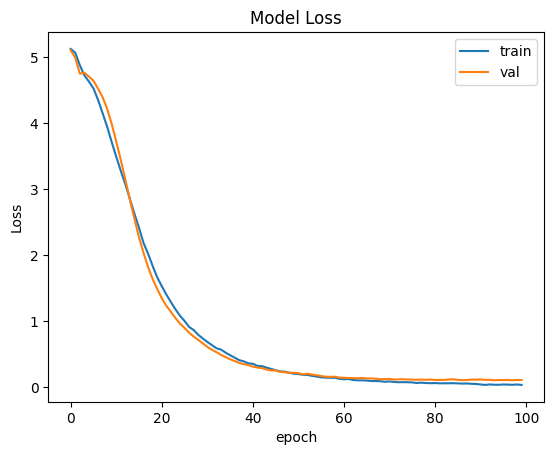

In [194]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [195]:
# context = vectorizer('Kau genggam kedua tanganku saat aku merasa takut Kaulah yang')
context = data[:context_size]
decode(context)

'kau adalah separuh hidup ku hanya kepadamu aku'

In [175]:
softmax = model(np.array([context]))

In [176]:
tf.math.log([[0.5, 0.8,0.3,.2,.2,.2,.2,.2,.2,.2]])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.6931472 , -0.22314355, -1.2039728 , -1.609438  , -1.609438  ,
        -1.609438  , -1.609438  , -1.609438  , -1.609438  , -1.609438  ]],
      dtype=float32)>

In [177]:
p = tf.random.categorical(softmax[-1,-1:],1)
decode(p[0])

'hidup'

In [178]:
decode(mini_batch[:1][0])

'kau adalah separuh hidup ku hanya kepadamu aku'

In [179]:
decode([tf.argmax(softmax[0,-1,:])])

'berbagi'

In [262]:
random = np.random.randint(100)
context = data[random:random+context_size]
context = vectorizer('aku yakin jiwamu yang kan selalu menghiasi hidupku')
decode(context)

'aku [UNK] [UNK] yang kan selalu menghiasi hidupku'

In [263]:
full_text = ''
for i in range(100):
  context_new = context[-context_size:]
  softmax = model(np.array([context_new]))

  prediction = tf.random.categorical(tf.math.log(softmax[-1,-1:]),1)
  full_text += decode(prediction[0])+' '
  context = tf.concat([context,prediction[0]],axis=0)

In [264]:
full_text

'selalu menghiasi harihariku selamanya kaulah diana mungkin kau membiarkan aku membiarkan perasaan ini larut memberi ruang jiwaku hampa agar tetap nikmati nikmati perangkap yang kau buat perisai yang banggakan takkan jadi tameng bagimu aku mengerti betapa hebatnya perangkap mu hei sang dewi ku akan nikmati akan selamanya bersinar bersinar secerah sang mentari pagi ya rabbi aku rabbi jangan engkau pisahkan antara akuibuku ya rabbi jangan engkau pisahkan antara akuibuku ya rabbi aku sungguh menyayanginya aku sepanjang zaman zaman yang zaman yang tak terhitungkan dia telah bersusah payah melahirkanku tanpa ku sadari aku telah sering menyakiti menyakiti hati ibuku ibuku ibuku '

In [151]:
tf.random.categorical(tf.math.log([[.3,.1,.6]]),100)

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0,
        2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2,
        2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2,
        0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2,
        2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2]])>